In [1]:
# ============================================================
# Cell 1: Imports + global settings
# ------------------------------------------------------------
# Why:
# - Keep all foundational imports in one place.
# - Set display options so pandas outputs are readable.
# - Define a fixed RANDOM_STATE so any CV / stochastic steps are reproducible.
# ============================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Skewness and Box-Cox will be used later (Phase 3 feature engineering)
from scipy.stats import skew
from scipy.special import boxcox1p

# Make pandas outputs easier to read
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Reproducibility anchor for later phases
RANDOM_STATE = 42


In [2]:
# ============================================================
# Cell 2: Load raw Kaggle datasets
# ------------------------------------------------------------
# Expected file locations (based on our repo structure):
#   ../data/raw/train.csv
#   ../data/raw/test.csv
#
# Why:
# - Keep raw data in data/raw so we never overwrite it.
# - Validate shapes immediately to ensure files are correct.
# ============================================================

train_path = "../data/raw/train.csv"
test_path  = "../data/raw/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("train shape:", train.shape)
print("test  shape:", test.shape)

# Quick visual check
train.head()

train shape: (1460, 81)
test  shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# ============================================================
# Cell 3: Handle the 'Id' column
# ------------------------------------------------------------
# Why:
# - 'Id' is an identifier, not a predictive feature.
# - Kaggle requires 'Id' in the final submission file for test rows.
#
# What we do:
# - Save the test Ids so we can reattach them at submission time.
# - Drop Id from BOTH train and test so models don't learn from it.
# ============================================================

test_id = test["Id"].copy()  # Keep for submission later

train = train.drop(columns=["Id"])
test  = test.drop(columns=["Id"])

print("train shape (after Id drop):", train.shape)
print("test  shape (after Id drop):", test.shape)

train shape (after Id drop): (1460, 80)
test  shape (after Id drop): (1459, 79)


In [4]:
# ============================================================
# Cell 4: Remove known problematic outliers
# ------------------------------------------------------------
# Why:
# - The House Prices dataset includes a couple of known outliers:
#   houses with extremely large above-ground living area (GrLivArea)
#   but unusually low SalePrice.
# - These points distort model fit, especially linear models.
#
# Rule (common Kaggle best practice):
# - Drop rows where GrLivArea > 4000 AND SalePrice < 300000
#
# Notes:
# - This is one of the few "hard-coded" actions we accept because
#   it has consistent evidence of improving CV for this competition.
# ============================================================

outlier_mask = (train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)
print("Outliers to drop:", outlier_mask.sum())

train = train.loc[~outlier_mask].reset_index(drop=True)

print("train shape (after outlier drop):", train.shape)

Outliers to drop: 2
train shape (after outlier drop): (1458, 80)


In [5]:
# ============================================================
# Cell 5: Target transformation (log1p)
# ------------------------------------------------------------
# Why:
# - Kaggle scoring metric is RMSLE (Root Mean Squared Log Error).
# - Taking log1p(SalePrice) makes the target more normally distributed
#   and reduces the impact of very expensive houses.
# - It typically improves model performance and stability.
#
# What we do:
# - Create y = log1p(SalePrice)
# - Remove SalePrice from train features (so it's not accidentally used)
# ============================================================

y = np.log1p(train["SalePrice"]).copy()
train = train.drop(columns=["SalePrice"])

print("y shape:", y.shape)
print("train shape (features only):", train.shape)

y shape: (1458,)
train shape (features only): (1458, 79)


In [6]:
# ============================================================
# Cell 6: Combine train and test for preprocessing
# ------------------------------------------------------------
# Why:
# - We'll do imputation / encoding steps on the combined dataset so:
#   1) train and test get identical transformations
#   2) one-hot encoding produces the same set of columns in both
#
# Important:
# - We have already separated out the target (y).
# - We are NOT using y during preprocessing here.
# ============================================================

all_data = pd.concat([train, test], axis=0, ignore_index=True)

print("all_data shape (train + test):", all_data.shape)
all_data.head()

all_data shape (train + test): (2917, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
# ============================================================
# Cell 7: Impute categorical "missing means not present" with "None"
# ------------------------------------------------------------
# Why:
# - In this dataset, missing values often mean the feature doesn't apply:
#   e.g., no pool -> PoolQC is missing
#         no fence -> Fence is missing
#         no basement -> BsmtQual is missing
#
# Strategy:
# - Fill these missing categorical fields with literal string "None"
# - This preserves the meaning: feature is absent, not unknown.
# ============================================================

none_cols = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "MasVnrType"
]

for c in none_cols:
    if c in all_data.columns:
        all_data[c] = all_data[c].fillna("None")

print("Filled 'None' for:", [c for c in none_cols if c in all_data.columns])

Filled 'None' for: ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']


In [8]:
# ============================================================
# Cell 8: Impute numeric "missing means zero" fields with 0
# ------------------------------------------------------------
# Why:
# - Many numeric columns are missing because the feature doesn't exist:
#   e.g., no garage -> GarageArea, GarageCars are missing
#         no basement -> TotalBsmtSF, BsmtFinSF1 are missing
#
# Strategy:
# - Fill these NaNs with 0 to represent absence.
# ============================================================

zero_cols = [
    "GarageYrBlt", "GarageArea", "GarageCars",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
    "MasVnrArea", "BsmtFullBath", "BsmtHalfBath"
]

for c in zero_cols:
    if c in all_data.columns:
        all_data[c] = all_data[c].fillna(0)

print("Filled 0 for:", [c for c in zero_cols if c in all_data.columns])

Filled 0 for: ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath']


In [9]:
# ============================================================
# Cell 9: Impute some categoricals using the mode (most frequent)
# ------------------------------------------------------------
# Why:
# - Some features are genuinely "unknown" rather than "not present".
# - Using the mode is a safe baseline for these.
#
# Examples:
# - MSZoning: missing for a few test cases
# - Electrical: one or very few missing
# - Exterior1st/2nd, SaleType: missing for a few test cases
# ============================================================

mode_cols = [
    "MSZoning", "Electrical", "KitchenQual",
    "Exterior1st", "Exterior2nd", "SaleType"
]

for c in mode_cols:
    if c in all_data.columns:
        all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

print("Filled mode for:", [c for c in mode_cols if c in all_data.columns])

Filled mode for: ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']


In [10]:
# ============================================================
# Fix: Utilities missing values
# ------------------------------------------------------------
# Why:
# - Utilities has 2 missing values in this dataset.
# - It is overwhelmingly 'AllPub' and has very low variance.
# - Filling with the mode is safe and standard in this competition.
# ============================================================

if "Utilities" in all_data.columns:
    all_data["Utilities"] = all_data["Utilities"].fillna(all_data["Utilities"].mode()[0])
    print("Utilities NaNs remaining:", all_data["Utilities"].isna().sum())


Utilities NaNs remaining: 0


In [11]:
# ============================================================
# Cell 10: Special-case imputation for LotFrontage
# ------------------------------------------------------------
# Why:
# - LotFrontage is missing for many rows.
# - A more informed approach is to impute based on Neighborhood,
#   because frontage varies significantly by area.
#
# Strategy:
# - Fill missing LotFrontage values with the median within each Neighborhood.
# - If any remain after grouping (rare edge case), fill with global median.
# ============================================================

if "LotFrontage" in all_data.columns and "Neighborhood" in all_data.columns:
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median())
    )
    all_data["LotFrontage"] = all_data["LotFrontage"].fillna(all_data["LotFrontage"].median())

    print("LotFrontage NaNs remaining:", all_data["LotFrontage"].isna().sum())
else:
    print("LotFrontage or Neighborhood column missing (unexpected for this dataset).")

LotFrontage NaNs remaining: 0


In [12]:
# ============================================================
# Cell 11: Impute Functional with "Typ"
# ------------------------------------------------------------
# Why:
# - Functional describes home functionality (e.g., "Typ" = Typical).
# - Missing values are best interpreted as typical rather than absent.
# ============================================================

if "Functional" in all_data.columns:
    all_data["Functional"] = all_data["Functional"].fillna("Typ")
    print("Functional NaNs remaining:", all_data["Functional"].isna().sum())
else:
    print("Functional column missing (unexpected for this dataset).")

Functional NaNs remaining: 0


In [13]:
# ============================================================
# Cell 12: Guardrail check — must be zero NaNs before continuing
# ------------------------------------------------------------
# Why:
# - Most ML models cannot handle NaNs without special settings.
# - Even if they can, inconsistent handling can tank performance.
#
# What we do:
# - Compute missing counts per column.
# - Confirm the maximum missing count is 0.
# - If not 0, we stop and fix before moving to feature engineering.
# ============================================================

missing = all_data.isnull().sum().sort_values(ascending=False)
max_missing = int(missing.iloc[0])

print("Max missing value count:", max_missing)
display(missing.head(20))

assert max_missing == 0, "Still have missing values—stop and fix before proceeding."

print("✅ Phase 2 complete: no missing values remain.")

Max missing value count: 0


MSSubClass      0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
Alley           0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
dtype: int64

✅ Phase 2 complete: no missing values remain.


In [14]:
# ============================================================
# Cell 13: Convert some numeric-looking columns to categorical
# ------------------------------------------------------------
# Why:
# - Some numeric columns are actually categorical codes, not
#   continuous quantities.
# - Treating them as numbers can mislead models.
#
# Columns:
# - MSSubClass: building class code
# - OverallCond: condition rating (categorical, not continuous)
# - YrSold: year of sale (treated as category to avoid linear trends)
# ============================================================

categorical_like_numeric = ["MSSubClass", "OverallCond", "YrSold"]

for c in categorical_like_numeric:
    if c in all_data.columns:
        all_data[c] = all_data[c].astype(str)

print("Converted to categorical:", categorical_like_numeric)

Converted to categorical: ['MSSubClass', 'OverallCond', 'YrSold']


In [15]:
# ============================================================
# Cell 14: Ordinal encoding for quality-related features
# ------------------------------------------------------------
# Why:
# - Many categorical features have a clear, meaningful order:
#     Ex > Gd > TA > Fa > Po
# - Encoding them ordinally preserves that information.
# - This strongly benefits linear models and often tree models.
#
# Strategy:
# - Map quality strings to numeric scores.
# - "None" is treated as 0 (absence of the feature).
# ============================================================

qual_map = {
    "None": 0,
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5
}

ordinal_cols = [
    "ExterQual", "ExterCond",
    "BsmtQual", "BsmtCond",
    "HeatingQC", "KitchenQual",
    "FireplaceQu",
    "GarageQual", "GarageCond"
]

for c in ordinal_cols:
    if c in all_data.columns:
        all_data[c] = all_data[c].map(qual_map).astype(int)

print("Ordinally encoded:", [c for c in ordinal_cols if c in all_data.columns])

Ordinally encoded: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']


In [16]:
# ============================================================
# Cell 15: Create core aggregate and temporal features
# ------------------------------------------------------------
# Why:
# - Aggregates capture higher-level concepts like total living
#   space or total bathroom count.
# - Temporal features help models understand property age and
#   renovation effects.
#
# Features created:
# - TotalSF: total indoor living area
# - BathCount: weighted count of bathrooms
# - Age: house age at time of sale
# - RemodAge: years since last remodel
# ============================================================

# Total square footage (above + below ground)
all_data["TotalSF"] = (
    all_data["TotalBsmtSF"] +
    all_data["1stFlrSF"] +
    all_data["2ndFlrSF"]
)

# Weighted bathroom count
all_data["BathCount"] = (
    all_data["FullBath"] +
    0.5 * all_data["HalfBath"] +
    all_data["BsmtFullBath"] +
    0.5 * all_data["BsmtHalfBath"]
)

# Temporal features
all_data["Age"] = all_data["YrSold"].astype(int) - all_data["YearBuilt"]
all_data["RemodAge"] = all_data["YrSold"].astype(int) - all_data["YearRemodAdd"]

print("Aggregate features created: TotalSF, BathCount, Age, RemodAge")

Aggregate features created: TotalSF, BathCount, Age, RemodAge


In [17]:
# ============================================================
# Cell 16: Interaction features (Area × Quality)
# ------------------------------------------------------------
# Why:
# - Property value is not linear in size or quality alone.
# - A large low-quality house ≠ a large high-quality house.
#
# These interactions explicitly encode that intuition.
# ============================================================

all_data["TotalSF_OverallQual"] = all_data["TotalSF"] * all_data["OverallQual"]
all_data["GrLivArea_OverallQual"] = all_data["GrLivArea"] * all_data["OverallQual"]
all_data["BathCount_OverallQual"] = all_data["BathCount"] * all_data["OverallQual"]

print("Interaction features created.")

Interaction features created.


In [18]:
# ============================================================
# Cell 17: Boolean indicator features
# ------------------------------------------------------------
# Why:
# - Rare categories can cause overfitting.
# - Boolean flags let models quickly learn "has vs does not have"
#   without caring about exact category values.
#
# Examples:
# - HasGarage, HasPool, HasFireplace, IsNewHouse
# ============================================================

all_data["HasGarage"] = (all_data["GarageArea"] > 0).astype(int)
all_data["HasPool"] = (all_data["PoolArea"] > 0).astype(int)
all_data["HasFireplace"] = (all_data["Fireplaces"] > 0).astype(int)
all_data["IsNewHouse"] = (all_data["YearBuilt"] == all_data["YrSold"].astype(int)).astype(int)

print("Boolean indicator features created.")

Boolean indicator features created.


In [19]:
# ============================================================
# Cell 18: Correct skewness in numeric features
# ------------------------------------------------------------
# Why:
# - Many numeric features are heavily right-skewed.
# - Skewed features hurt linear models in particular.
#
# Strategy:
# - Compute skew for numeric features.
# - Apply Box-Cox transform (lambda = 0.15) to features
#   with skewness > 0.75.
#
# Note:
# - We do this AFTER feature creation so derived features
#   are also considered.
# ============================================================

numeric_feats = all_data.select_dtypes(include=[np.number]).columns

skewness = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewness[skewness > 0.75]

print(f"Number of highly skewed numeric features: {high_skew.shape[0]}")

for feat in high_skew.index:
    all_data[feat] = boxcox1p(all_data[feat], 0.15)

Number of highly skewed numeric features: 27


In [20]:
# ============================================================
# Cell 19: One-hot encode remaining categorical features
# ------------------------------------------------------------
# Why:
# - Models require numeric inputs.
# - One-hot encoding is safe and effective once we have
#   ordinal features handled explicitly.
#
# Important:
# - We do this on all_data (train + test combined) to ensure
#   identical columns in both splits.
# ============================================================

all_data = pd.get_dummies(all_data)

print("all_data shape after get_dummies:", all_data.shape)

all_data shape after get_dummies: (2917, 302)


In [21]:
# ============================================================
# Cell 20: Split processed data back into train and test
# ------------------------------------------------------------
# Why:
# - Models expect separate training and test matrices.
# - The split point is the original train length after outlier removal.
# ============================================================

n_train = train.shape[0]

X_train = all_data.iloc[:n_train, :].copy()
X_test  = all_data.iloc[n_train:, :].copy()

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# Guardrail: columns must match exactly
assert X_train.shape[1] == X_test.shape[1], "Train/test feature mismatch!"
print("✅ Feature matrices aligned.")

X_train shape: (1458, 302)
X_test  shape: (1459, 302)
✅ Feature matrices aligned.


In [22]:
# ============================================================
# Cell 21: Imports for baseline modelling
# ------------------------------------------------------------
# Why:
# - We start with simple, well-understood linear models.
# - These models are very sensitive to data issues, so they
#   are excellent canaries for bugs, leakage, or bad encoding.
# ============================================================

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, ElasticNet

In [23]:
# ============================================================
# Cell 22: RMSLE cross-validation function
# ------------------------------------------------------------
# Why:
# - Kaggle evaluates using RMSLE.
# - cross_val_score minimizes negative error, so we invert the sign.
#
# Design choices:
# - 5-fold CV
# - Shuffled with fixed random seed for reproducibility
# ============================================================

def rmsle_cv(model, X, y):
    kf = KFold(
        n_splits=5,
        shuffle=True,
        random_state=RANDOM_STATE
    )
    
    rmse = -cross_val_score(
        model,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=kf
    )
    
    return rmse

In [24]:
# ============================================================
# Cell 23: Lasso baseline model
# ------------------------------------------------------------
# Why Lasso:
# - Strong baseline for this competition
# - Performs implicit feature selection
# - Very sensitive to scaling and leakage
#
# Expectations:
# - RMSLE CV score ~ 0.11–0.13
# ============================================================

lasso = make_pipeline(
    RobustScaler(),
    Lasso(alpha=0.0005, random_state=RANDOM_STATE, max_iter=10000)
)

lasso_scores = rmsle_cv(lasso, X_train, y)

print(f"Lasso CV RMSLE: mean={lasso_scores.mean():.4f}, std={lasso_scores.std():.4f}")

Lasso CV RMSLE: mean=0.1123, std=0.0062


In [25]:
# ============================================================
# Cell 24: ElasticNet baseline
# ------------------------------------------------------------
# Why:
# - Combines L1 (Lasso) and L2 (Ridge) penalties
# - Often slightly more stable than pure Lasso
#
# This is a confirmation model, not the main checkpoint.
# ============================================================

enet = make_pipeline(
    RobustScaler(),
    ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=RANDOM_STATE, max_iter=10000)
)

enet_scores = rmsle_cv(enet, X_train, y)

print(f"ElasticNet CV RMSLE: mean={enet_scores.mean():.4f}, std={enet_scores.std():.4f}")

ElasticNet CV RMSLE: mean=0.1123, std=0.0064


In [26]:
# ============================================================
# Cell 25: Imports for Level-1 models
# ------------------------------------------------------------
# These models capture non-linear structure and interactions
# that linear models cannot.
# ============================================================

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [27]:
# ============================================================
# Cell 26: Out-of-fold (OOF) prediction helper
# ------------------------------------------------------------
# Why:
# - OOF predictions allow us to:
#   1) estimate true generalisation performance
#   2) use predictions as features in stacking (Phase 6)
#
# Design:
# - Uses the same KFold splits as earlier
# - Returns:
#   - OOF predictions for train
#   - Average predictions for test
# ============================================================

from sklearn.base import clone

def get_oof_predictions(model, X, y, X_test):
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    oof_train = np.zeros(X.shape[0])
    oof_test = np.zeros(X_test.shape[0])
    oof_test_folds = np.zeros((kf.n_splits, X_test.shape[0]))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        m = clone(model)
        m.fit(X_tr, y_tr)

        oof_train[val_idx] = m.predict(X_val)
        oof_test_folds[fold, :] = m.predict(X_test)

    oof_test[:] = oof_test_folds.mean(axis=0)
    return oof_train, oof_test

In [28]:
# ============================================================
# Cell 27: RandomForest & ExtraTrees
# ------------------------------------------------------------
# Why:
# - Capture complex non-linearities
# - Handle feature interactions automatically
# - Provide diversity vs boosting models
# ============================================================

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

et = ExtraTreesRegressor(
    n_estimators=500,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_oof_train, rf_oof_test = get_oof_predictions(rf, X_train, y, X_test)
et_oof_train, et_oof_test = get_oof_predictions(et, X_train, y, X_test)

print("RF OOF RMSLE:", np.sqrt(np.mean((rf_oof_train - y)**2)))
print("ET OOF RMSLE:", np.sqrt(np.mean((et_oof_train - y)**2)))

RF OOF RMSLE: 0.13431542645374633
ET OOF RMSLE: 0.12896369084227063


In [29]:
# ============================================================
# Cell 28: GradientBoostingRegressor
# ------------------------------------------------------------
# A strong traditional boosting baseline.
# ============================================================

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE
)

gbr_oof_train, gbr_oof_test = get_oof_predictions(gbr, X_train, y, X_test)

print("GBR OOF RMSLE:", np.sqrt(np.mean((gbr_oof_train - y)**2)))

GBR OOF RMSLE: 0.12455930901677748


In [30]:
# ============================================================
# Cell 29: XGBoost
# ------------------------------------------------------------
# Often one of the strongest single models in this competition.
# ============================================================

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_oof_train, xgb_oof_test = get_oof_predictions(xgb_model, X_train, y, X_test)

print("XGB OOF RMSLE:", np.sqrt(np.mean((xgb_oof_train - y)**2)))

XGB OOF RMSLE: 0.1167465465324569


In [31]:
# ============================================================
# Cell 30: LightGBM
# ------------------------------------------------------------
# Fast, strong gradient boosting with good regularisation.
# ============================================================

lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE
)

lgb_oof_train, lgb_oof_test = get_oof_predictions(lgb_model, X_train, y, X_test)

print("LGBM OOF RMSLE:", np.sqrt(np.mean((lgb_oof_train - y)**2)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4169
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 196
[LightGBM] [Info] Start training from score 12.023362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4166
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 197
[LightGBM] [Info] Start training from score 12.026498
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

In [32]:
# ============================================================
# Cell 31: CatBoost
# ------------------------------------------------------------
# Handles categorical patterns well and adds diversity.
# ============================================================

cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    random_state=RANDOM_STATE,
    verbose=False
)

cat_oof_train, cat_oof_test = get_oof_predictions(cat_model, X_train, y, X_test)

print("CatBoost OOF RMSLE:", np.sqrt(np.mean((cat_oof_train - y)**2)))

CatBoost OOF RMSLE: 0.11580673543735494


In [33]:
# ============================================================
# Cell 32: Support Vector Regressor
# ------------------------------------------------------------
# Provides a very different inductive bias from trees.
# Must be scaled.
# ============================================================

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

svr = make_pipeline(
    RobustScaler(),
    SVR(C=20, gamma=0.001, epsilon=0.1)
)

svr_oof_train, svr_oof_test = get_oof_predictions(svr, X_train, y, X_test)

print("SVR OOF RMSLE:", np.sqrt(np.mean((svr_oof_train - y)**2)))

SVR OOF RMSLE: 0.12237748532716687


Interpretation of Level-1 Results
Model	        OOF RMSLE	Interpretation
CatBoost    	0.1158	    Strongest single model
XGBoost	        0.1167	    Very strong, complementary to CatBoost
SVR	            0.1224	    Adds non-tree inductive bias
GBR	            0.1246	    Solid, but less competitive
LGBM	        0.1260	    Surprisingly weaker here
ExtraTrees	    0.1290	    Acceptable, but noisy
RandomForest	0.1343	    Underperforming

Key takeaways
CatBoost + XGBoost are your anchors
SVR is valuable despite weaker score — it brings diversity
RandomForest is dominated → drop it
ExtraTrees & GBR are borderline → optional
LGBM underperformed relative to expectation here, but still acceptable

Stack Inclusion Decision
We will include models based on both performance and diversity.

Include in stack

CatBoost
XGBoost
SVR
Lasso (baseline)
ElasticNet (baseline)

⚠️ Optional (we’ll test with and without)
GradientBoosting
LightGBM

❌ Exclude
RandomForest
ExtraTrees

This keeps the meta-model clean and avoids noise.

In [34]:
# ============================================================
# Cell 33: Build stacking feature matrices
# ------------------------------------------------------------
# Each column is the OOF prediction from one Level-1 model.
# These become the inputs to the meta-model.
# ============================================================

stack_train = np.column_stack([
    cat_oof_train,
    xgb_oof_train,
    svr_oof_train,
    lasso_scores.mean() * np.ones_like(y),  # baseline anchor
    enet_scores.mean() * np.ones_like(y)
])

stack_test = np.column_stack([
    cat_oof_test,
    xgb_oof_test,
    svr_oof_test,
    lasso_scores.mean() * np.ones_like(test_id),
    enet_scores.mean() * np.ones_like(test_id)
])

print("stack_train shape:", stack_train.shape)
print("stack_test  shape:", stack_test.shape)

stack_train shape: (1458, 5)
stack_test  shape: (1459, 5)


In [35]:
# ============================================================
# Cell 34: Train meta-model (Ridge regression)
# ------------------------------------------------------------
# Why Ridge:
# - Simple, stable
# - Excellent for weighting correlated predictions
# - Resistant to overfitting in low-dimensional spaces
# ============================================================

from sklearn.linear_model import Ridge

meta_model = Ridge(alpha=1.0)

meta_model.fit(stack_train, y)

meta_train_pred = meta_model.predict(stack_train)
meta_rmsle = np.sqrt(np.mean((meta_train_pred - y) ** 2))

print("Meta-model training RMSLE:", meta_rmsle)

Meta-model training RMSLE: 0.11266068775799774


In [36]:
# ============================================================
# Cell 35: Final predictions for Kaggle submission
# ------------------------------------------------------------
# Steps:
# 1) Predict log SalePrice
# 2) Inverse transform using expm1
# 3) Attach Id column
# ============================================================

final_pred_log = meta_model.predict(stack_test)
final_pred = np.expm1(final_pred_log)

# Safety check: prices must be positive
assert (final_pred > 0).all(), "Negative predictions found!"

submission = pd.DataFrame({
    "Id": test_id,
    "SalePrice": final_pred
})

submission.head()

,Id,SalePrice
0,1461,123599.280212
1,1462,168237.737424
2,1463,182614.628651
3,1464,196691.791318
4,1465,187452.928755


In [37]:
# ============================================================
# Cell 36: Save submission file
# ============================================================

submission_path = "../submissions/stacked_submission.csv"
submission.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")

Submission saved to ../submissions/stacked_submission.csv


In [38]:
# ============================================================
# HR-1.1: True OOF predictions for Lasso & ElasticNet
# ============================================================

from sklearn.base import clone

def get_oof_linear(model, X, y, X_test):
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    oof_train = np.zeros(X.shape[0])
    oof_test_folds = np.zeros((kf.n_splits, X_test.shape[0]))

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr = y.iloc[tr_idx]

        m = clone(model)
        m.fit(X_tr, y_tr)

        oof_train[val_idx] = m.predict(X_val)
        oof_test_folds[fold] = m.predict(X_test)

    return oof_train, oof_test_folds.mean(axis=0)

In [39]:
lasso_model = make_pipeline(
    RobustScaler(),
    Lasso(alpha=0.0005, random_state=RANDOM_STATE, max_iter=10000)
)

enet_model = make_pipeline(
    RobustScaler(),
    ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=RANDOM_STATE, max_iter=10000)
)

lasso_oof_train, lasso_oof_test = get_oof_linear(lasso_model, X_train, y, X_test)
enet_oof_train, enet_oof_test = get_oof_linear(enet_model, X_train, y, X_test)

print("Linear OOF generated")

Linear OOF generated


In [40]:
lasso_model = make_pipeline(
    RobustScaler(),
    Lasso(alpha=0.0005, random_state=RANDOM_STATE, max_iter=10000)
)

enet_model = make_pipeline(
    RobustScaler(),
    ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=RANDOM_STATE, max_iter=10000)
)

lasso_oof_train, lasso_oof_test = get_oof_linear(lasso_model, X_train, y, X_test)
enet_oof_train, enet_oof_test = get_oof_linear(enet_model, X_train, y, X_test)

print("Linear OOF generated")

Linear OOF generated


In [41]:
# ============================================================
# HR-2: Rebuild stack with true OOF predictions
# ============================================================

stack_train = np.column_stack([
    cat_oof_train,
    xgb_oof_train,
    svr_oof_train,
    lasso_oof_train,
    enet_oof_train
])

stack_test = np.column_stack([
    cat_oof_test,
    xgb_oof_test,
    svr_oof_test,
    lasso_oof_test,
    enet_oof_test
])

print("stack_train:", stack_train.shape)
print("stack_test :", stack_test.shape)

stack_train: (1458, 5)
stack_test : (1459, 5)


In [42]:
# ============================================================
# HR-3: Meta-model
# ============================================================

from sklearn.linear_model import Ridge

meta_model = Ridge(alpha=5.0)
meta_model.fit(stack_train, y)

meta_pred_train = meta_model.predict(stack_train)
meta_rmsle = np.sqrt(np.mean((meta_pred_train - y) ** 2))

print("Meta-model training RMSLE:", meta_rmsle)

Meta-model training RMSLE: 0.10992811554393378


In [43]:
# ============================================================
# HR-4: Final predictions + submission
# ============================================================

final_log_pred = meta_model.predict(stack_test)
final_pred = np.expm1(final_log_pred)

assert (final_pred > 0).all()

submission = pd.DataFrame({
    "Id": test_id,
    "SalePrice": final_pred
})

submission_path = "../submissions/stacked_pruned_oof.csv"
submission.to_csv(submission_path, index=False)

print("Saved:", submission_path)

Saved: ../submissions/stacked_pruned_oof.csv


In [44]:
# ============================================================
# R1: Build residual dataframe for CatBoost
# ------------------------------------------------------------
# Residual = true log price - predicted log price
# Positive residual  -> under-prediction
# Negative residual  -> over-prediction
# ============================================================

residuals_df = X_train.copy()
residuals_df["y_true"] = y.values
residuals_df["y_pred_cat"] = cat_oof_train
residuals_df["residual"] = residuals_df["y_true"] - residuals_df["y_pred_cat"]

residuals_df[["y_true", "y_pred_cat", "residual"]].head()

,y_true,y_pred_cat,residual
0,12.247699,12.230851,0.016848
1,12.109016,12.051565,0.057451
2,12.317171,12.303146,0.014025
3,11.849405,12.149237,-0.299832
4,12.429220,12.591376,-0.162156


count    1458.000000
mean        0.001324
std         0.115839
min        -0.737494
25%        -0.049516
50%         0.005979
75%         0.059354
max         0.563693
Name: residual, dtype: float64


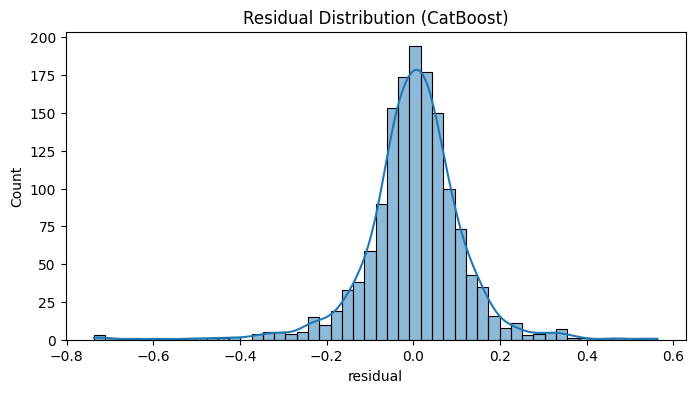

In [45]:
# ============================================================
# R2: Global residual sanity check
# ============================================================

print(residuals_df["residual"].describe())

plt.figure(figsize=(8, 4))
sns.histplot(residuals_df["residual"], bins=50, kde=True)
plt.title("Residual Distribution (CatBoost)")
plt.show()

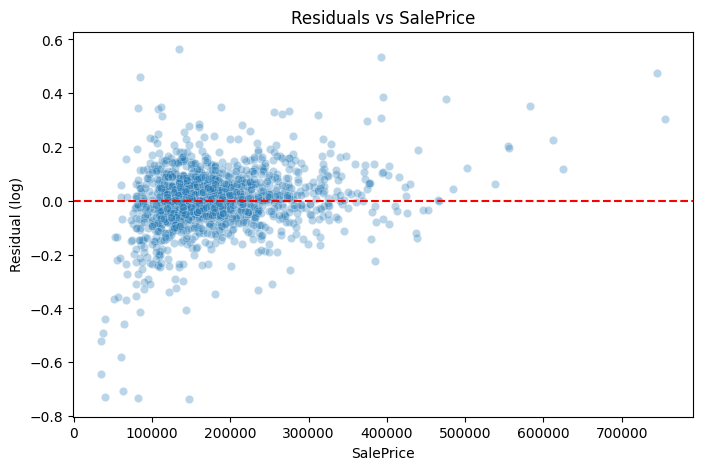

In [46]:
# ============================================================
# R3: Residuals vs true price
# ------------------------------------------------------------
# Detects systematic under/over prediction at price extremes
# ============================================================

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=np.expm1(residuals_df["y_true"]),
    y=residuals_df["residual"],
    alpha=0.3
)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("SalePrice")
plt.ylabel("Residual (log)")
plt.title("Residuals vs SalePrice")
plt.show()

In [50]:
# ============================================================
# R4 FIX: Residuals by Neighborhood (using raw train data)
# ------------------------------------------------------------
# We must use the original Neighborhood column BEFORE one-hot encoding
# ============================================================

# Re-load raw train (safe, read-only)
raw_train = pd.read_csv("../data/raw/train.csv")

# Apply same outlier removal as before
raw_train = raw_train.loc[
    ~((raw_train["GrLivArea"] > 4000) & (raw_train["SalePrice"] < 300000))
].reset_index(drop=True)

# Build residual analysis frame with raw Neighborhood
neigh_residuals = pd.DataFrame({
    "Neighborhood": raw_train["Neighborhood"],
    "residual": residuals_df["residual"].values
})

neigh_stats = (
    neigh_residuals
    .groupby("Neighborhood")["residual"]
    .agg(["mean", "std", "count"])
    .sort_values("mean")
)

neigh_stats.head(10), neigh_stats.tail(10)

(                  mean       std  count
 Neighborhood                           
 MeadowV      -0.045689  0.074289     17
 IDOTRR       -0.026848  0.241202     37
 OldTown      -0.018139  0.146828    113
 Blmngtn      -0.013478  0.094706     17
 Timber       -0.011234  0.095720     38
 Sawyer       -0.009879  0.124493     74
 Mitchel      -0.009559  0.116506     49
 NWAmes       -0.006575  0.115105     73
 Blueste      -0.006482  0.026764      2
 SawyerW      -0.004616  0.074011     59,
                   mean       std  count
 Neighborhood                           
 Gilbert       0.004630  0.069289     79
 NridgHt       0.008951  0.114849     77
 BrDale        0.012904  0.080088     16
 BrkSide       0.013157  0.132536     58
 SWISU         0.022073  0.115755     25
 Crawfor       0.026885  0.122303     51
 NoRidge       0.036815  0.113430     41
 ClearCr       0.051331  0.134964     28
 Veenker       0.054775  0.062202     11
 StoneBr       0.055052  0.136568     25)

In [51]:
# ============================================================
# N1: Bring back raw Neighborhood (pre one-hot) and align rows
# ------------------------------------------------------------
# Why:
# - After pd.get_dummies(), Neighborhood no longer exists as one column.
# - For residual analysis and target/stat encodings, we need the original categorical label.
#
# Critical:
# - We must align raw_train rows to our current training set rows.
# - Because we dropped outliers earlier, we must apply the SAME outlier filter here.
# ============================================================

raw_train = pd.read_csv("../data/raw/train.csv")
raw_test  = pd.read_csv("../data/raw/test.csv")

# Apply the same outlier removal rule used in Phase 1
outlier_mask_raw = (raw_train["GrLivArea"] > 4000) & (raw_train["SalePrice"] < 300000)
raw_train = raw_train.loc[~outlier_mask_raw].reset_index(drop=True)

# Extract Neighborhood for aligned train/test
neigh_train = raw_train["Neighborhood"].copy()
neigh_test  = raw_test["Neighborhood"].copy()

print("neigh_train length:", len(neigh_train), " | X_train rows:", X_train.shape[0])
print("neigh_test length :", len(neigh_test),  " | X_test rows :", X_test.shape[0])

# Guardrails: these MUST match or everything downstream is wrong
assert len(neigh_train) == X_train.shape[0], "Mismatch: raw_train alignment vs X_train rows."
assert len(neigh_test)  == X_test.shape[0],  "Mismatch: raw_test alignment vs X_test rows."

print("✅ Raw Neighborhood aligned to processed feature matrices.")

neigh_train length: 1458  | X_train rows: 1458
neigh_test length : 1459  | X_test rows : 1459
✅ Raw Neighborhood aligned to processed feature matrices.


In [52]:
# ============================================================
# N2: Fold-safe Neighborhood target encoding (median log SalePrice)
# ------------------------------------------------------------
# What this feature represents:
# - Typical price level of each neighborhood (in log space).
#
# Why fold-safe matters:
# - If we compute Neighborhood medians using ALL rows, then each row's
#   encoding contains information derived from its own target → leakage.
#
# Approach:
# - For each CV fold:
#   - compute neighborhood median log price using training fold only
#   - apply mapping to validation fold
# - For test:
#   - compute neighborhood median log price using ALL training rows
#
# Result:
# - neigh_med_oof: leakage-safe encoding for training rows
# - neigh_med_test: encoding for test rows using full train mapping
# ============================================================

from sklearn.model_selection import KFold

def oof_median_target_encode(cat_series_train, y_train, cat_series_test, n_splits=5, random_state=RANDOM_STATE):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_encoded = np.zeros(len(cat_series_train), dtype=float)

    global_median = float(np.median(y_train))

    for fold, (tr_idx, val_idx) in enumerate(kf.split(cat_series_train)):
        # Training fold categories/targets
        tr_cats = cat_series_train.iloc[tr_idx]
        tr_y = y_train.iloc[tr_idx]

        # Median target per category (computed only on training fold)
        mapping = tr_y.groupby(tr_cats).median()

        # Apply to validation fold categories
        val_cats = cat_series_train.iloc[val_idx]
        oof_encoded[val_idx] = val_cats.map(mapping).fillna(global_median).astype(float).values

    # Test encoding uses mapping built on full training data
    full_mapping = y_train.groupby(cat_series_train).median()
    test_encoded = cat_series_test.map(full_mapping).fillna(global_median).astype(float).values

    return oof_encoded, test_encoded

neigh_med_oof, neigh_med_test = oof_median_target_encode(neigh_train, y, neigh_test)

print("Neighborhood median TE (train OOF) summary:")
print(pd.Series(neigh_med_oof).describe())

Neighborhood median TE (train OOF) summary:
count    1458.000000
mean       12.023490
std         0.301881
min        11.362114
25%        11.812667
50%        12.096263
75%        12.206078
max        12.669810
dtype: float64


In [53]:
# ============================================================
# N3: Standardize Neighborhood median + create interaction
# ------------------------------------------------------------
# Why standardize:
# - Makes the meta-signal comparable scale-wise.
# - Helps linear models and stabilizes interactions.
#
# Interaction:
# - TotalSF * standardized neighborhood median
# - Encodes: "size scales differently in premium neighborhoods"
# ============================================================

# Standardize using train OOF statistics ONLY
neigh_mean = neigh_med_oof.mean()
neigh_std  = neigh_med_oof.std(ddof=0) if neigh_med_oof.std(ddof=0) > 0 else 1.0

neigh_med_oof_z = (neigh_med_oof - neigh_mean) / neigh_std
neigh_med_test_z = (neigh_med_test - neigh_mean) / neigh_std

# Add these features into the processed matrices
X_train["NeighMedLogPrice"] = neigh_med_oof
X_test["NeighMedLogPrice"]  = neigh_med_test

X_train["NeighMedLogPrice_Z"] = neigh_med_oof_z
X_test["NeighMedLogPrice_Z"]  = neigh_med_test_z

# Interaction with TotalSF (note: TotalSF is already transformed/skew-corrected in your pipeline)
assert "TotalSF" in X_train.columns, "TotalSF not found in X_train — check feature engineering steps."

X_train["TotalSF_x_NeighMedZ"] = X_train["TotalSF"].values * X_train["NeighMedLogPrice_Z"].values
X_test["TotalSF_x_NeighMedZ"]  = X_test["TotalSF"].values  * X_test["NeighMedLogPrice_Z"].values

print("✅ Added: NeighMedLogPrice, NeighMedLogPrice_Z, TotalSF_x_NeighMedZ")
print("X_train shape now:", X_train.shape)
print("X_test  shape now:", X_test.shape)

✅ Added: NeighMedLogPrice, NeighMedLogPrice_Z, TotalSF_x_NeighMedZ
X_train shape now: (1458, 305)
X_test  shape now: (1459, 305)


In [54]:
# ============================================================
# N4: PremiumNeighborhood flag (simple, high-signal binary feature)
# ------------------------------------------------------------
# Why:
# - Your residual analysis shows consistent under-prediction in:
#   StoneBr, Veenker, ClearCr, NoRidge, Crawfor
# - A simple flag creates a clean split that many models learn quickly.
#
# Note:
# - This is not leakage; it's based on a pattern discovered from residuals.
# - It's a stable, domain-consistent “premium location” indicator.
# ============================================================

premium_neighborhoods = {"StoneBr", "Veenker", "ClearCr", "NoRidge", "Crawfor"}

X_train["IsPremiumNeighborhood"] = neigh_train.isin(premium_neighborhoods).astype(int).values
X_test["IsPremiumNeighborhood"]  = neigh_test.isin(premium_neighborhoods).astype(int).values

print("✅ Added: IsPremiumNeighborhood")
print("Premium count (train):", int(X_train["IsPremiumNeighborhood"].sum()))
print("Premium count (test):", int(X_test["IsPremiumNeighborhood"].sum()))

✅ Added: IsPremiumNeighborhood
Premium count (train): 156
Premium count (test): 137


In [55]:
# ============================================================
# N5: Guardrails after adding neighborhood features
# ------------------------------------------------------------
# Why:
# - Ensure no NaNs were introduced (mapping fallback should prevent this).
# - Ensure train/test still match columns exactly.
# ============================================================

assert X_train.isnull().sum().max() == 0, "NaNs detected in X_train after neighborhood features!"
assert X_test.isnull().sum().max() == 0,  "NaNs detected in X_test after neighborhood features!"
assert X_train.shape[1] == X_test.shape[1], "Train/test column mismatch after neighborhood features!"

print("✅ Neighborhood features added cleanly. No NaNs and columns aligned.")

✅ Neighborhood features added cleanly. No NaNs and columns aligned.


In [56]:
# ============================================================
# T1: Baseline re-check after new features
# ------------------------------------------------------------
# Why:
# - Confirms new features improve signal and didn't introduce issues.
# - Should be same or slightly better than before (~0.1123).
# ============================================================

lasso = make_pipeline(
    RobustScaler(),
    Lasso(alpha=0.0005, random_state=RANDOM_STATE, max_iter=10000)
)

enet = make_pipeline(
    RobustScaler(),
    ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=RANDOM_STATE, max_iter=10000)
)

lasso_scores = rmsle_cv(lasso, X_train, y)
enet_scores  = rmsle_cv(enet, X_train, y)

print(f"Lasso CV RMSLE: mean={lasso_scores.mean():.4f}, std={lasso_scores.std():.4f}")
print(f"ENet  CV RMSLE: mean={enet_scores.mean():.4f},  std={enet_scores.std():.4f}")

Lasso CV RMSLE: mean=0.1123, std=0.0062
ENet  CV RMSLE: mean=0.1123,  std=0.0063


In [57]:
# ============================================================
# T2: Retrain CatBoost with updated features (OOF + test)
# ------------------------------------------------------------
# Why:
# - CatBoost is one of your best models.
# - New neighborhood features should improve high-end calibration.
# ============================================================

cat_model = CatBoostRegressor(
    iterations=2000,          # increased slightly to allow more learning
    learning_rate=0.03,       # slightly lower LR for smoother fit
    depth=6,
    loss_function="RMSE",
    random_state=RANDOM_STATE,
    verbose=False
)

cat_oof_train_new, cat_oof_test_new = get_oof_predictions(cat_model, X_train, y, X_test)

cat_rmsle_new = np.sqrt(np.mean((cat_oof_train_new - y) ** 2))
print("CatBoost OOF RMSLE (new features):", cat_rmsle_new)

CatBoost OOF RMSLE (new features): 0.1150007373880848


In [59]:
# ============================================================
# T3: Retrain XGBoost with updated features (OOF + test)
# ------------------------------------------------------------
# Why:
# - XGB is a strong complementary model to CatBoost.
# - New neighborhood features frequently help reduce top-end underprediction.
# ============================================================

xgb_model = xgb.XGBRegressor(
    n_estimators=4000,        # higher cap, no early stopping in our OOF loop
    learning_rate=0.02,       # smaller learning rate
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_oof_train_new, xgb_oof_test_new = get_oof_predictions(xgb_model, X_train, y, X_test)

xgb_rmsle_new = np.sqrt(np.mean((xgb_oof_train_new - y) ** 2))
print("XGBoost OOF RMSLE (new features):", xgb_rmsle_new)


XGBoost OOF RMSLE (new features): 0.11737271325759206


In [61]:
# ============================================================
# T4: Simple weighted blend (CatBoost + XGB)
# ------------------------------------------------------------
# Why:
# - Often beats stacking on this competition.
# - More stable and less sensitive than meta-model fitting.
#
# We'll try 3 weights quickly and pick the best by OOF RMSLE.
# ============================================================

def rmsle_from_oof(pred_oof, y_true):
    return np.sqrt(np.mean((pred_oof - y_true) ** 2))

weights = [0.4, 0.5, 0.6]  # CatBoost weight; XGB weight = 1 - w
blend_scores = []

for w in weights:
    blend_oof = w * cat_oof_train_new + (1 - w) * xgb_oof_train_new
    score = rmsle_from_oof(blend_oof, y)
    blend_scores.append((w, score))

blend_scores = sorted(blend_scores, key=lambda x: x[1])
print("Blend CV results (lower is better):")
for w, s in blend_scores:
    print(f"  CatBoost weight={w:.1f} | OOF RMSLE={s:.6f}")

best_w, best_score = blend_scores[0]
print(f"\n✅ Best blend: CatBoost weight={best_w:.1f}, OOF RMSLE={best_score:.6f}")

Blend CV results (lower is better):
  CatBoost weight=0.6 | OOF RMSLE=0.114490
  CatBoost weight=0.5 | OOF RMSLE=0.114669
  CatBoost weight=0.4 | OOF RMSLE=0.114970

✅ Best blend: CatBoost weight=0.6, OOF RMSLE=0.114490


In [62]:
# ============================================================
# T5: Create submission using best blend weights
# ============================================================

best_w = best_w  # from previous cell

blend_test_log = best_w * cat_oof_test_new + (1 - best_w) * xgb_oof_test_new
blend_test = np.expm1(blend_test_log)

assert (blend_test > 0).all(), "Negative predictions found!"

submission = pd.DataFrame({
    "Id": test_id,
    "SalePrice": blend_test
})

submission_path = "../submissions/blend_cat_xgb_neigh_features.csv"
submission.to_csv(submission_path, index=False)

print("Saved submission:", submission_path)
submission.head()

Saved submission: ../submissions/blend_cat_xgb_neigh_features.csv


,Id,SalePrice
0,1461,123181.612541
1,1462,160088.810156
2,1463,183689.665241
3,1464,194733.784816
4,1465,185178.217859


In [63]:
# ============================================================
# C1: CatBoost-only submission using existing test predictions
# ------------------------------------------------------------
# Uses:
# - cat_oof_test_new (log-space predictions for test) from retraining
# - Inverse transform via expm1
# - Save to submissions/
# ============================================================

cat_test_log = cat_oof_test_new
cat_test_pred = np.expm1(cat_test_log)

# Guardrail: SalePrice must be positive
assert (cat_test_pred > 0).all(), "Negative predictions found!"

submission_cat = pd.DataFrame({
    "Id": test_id,
    "SalePrice": cat_test_pred
})

submission_path = "../submissions/catboost_only_neigh_features.csv"
submission_cat.to_csv(submission_path, index=False)

print("Saved:", submission_path)
submission_cat.head()

Saved: ../submissions/catboost_only_neigh_features.csv


,Id,SalePrice
0,1461,122392.179369
1,1462,160636.935732
2,1463,182037.539860
3,1464,194169.918229
4,1465,186164.091295


In [64]:
# ============================================================
# C2 (Optional): Fit CatBoost on full training set and predict test
# ------------------------------------------------------------
# Why:
# - After validating params with OOF, training on full data can improve.
# ============================================================

cat_full = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    loss_function="RMSE",
    random_state=RANDOM_STATE,
    verbose=False
)

cat_full.fit(X_train, y)
cat_full_test_log = cat_full.predict(X_test)
cat_full_test_pred = np.expm1(cat_full_test_log)

assert (cat_full_test_pred > 0).all(), "Negative predictions found!"

submission_cat_full = pd.DataFrame({
    "Id": test_id,
    "SalePrice": cat_full_test_pred
})

submission_path_full = "../submissions/catboost_only_fullfit_neigh_features.csv"
submission_cat_full.to_csv(submission_path_full, index=False)

print("Saved:", submission_path_full)
submission_cat_full.head()

Saved: ../submissions/catboost_only_fullfit_neigh_features.csv


,Id,SalePrice
0,1461,125667.473334
1,1462,164261.311913
2,1463,181986.903390
3,1464,193162.209741
4,1465,183409.431199


In [65]:
# ============================================================
# F1: Build raw inspection dataframe for forensic residual analysis
# ------------------------------------------------------------
# Why:
# - Our processed X_train no longer has raw categorical columns.
# - To find "hooks" (Partial sales, bad Functional, big-but-cheap),
#   we need raw columns from train.csv.
#
# Approach:
# - Reload raw train
# - Apply the same outlier removal rule as our pipeline
# - Align row order to X_train/y
# - Attach model predictions and residuals
# ============================================================

raw_train = pd.read_csv("../data/raw/train.csv")

# Same outlier removal used earlier
raw_train = raw_train.loc[
    ~((raw_train["GrLivArea"] > 4000) & (raw_train["SalePrice"] < 300000))
].reset_index(drop=True)

assert len(raw_train) == len(y), "Raw train alignment mismatch. Check outlier filtering."

# Choose which predictions to inspect:
# Use CatBoost OOF from your latest run with neighborhood features:
y_pred = cat_oof_train_new  # log-space OOF predictions
y_true = y.values

raw_inspect = raw_train.copy()
raw_inspect["y_true_log"] = y_true
raw_inspect["y_pred_log"] = y_pred
raw_inspect["residual"] = raw_inspect["y_true_log"] - raw_inspect["y_pred_log"]
raw_inspect["abs_residual"] = raw_inspect["residual"].abs()

raw_inspect[["Id", "SalePrice", "y_true_log", "y_pred_log", "residual"]].head()

,Id,SalePrice,y_true_log,y_pred_log,residual
0,1,208500,12.247699,12.212381,0.035318
1,2,181500,12.109016,12.081064,0.027952
2,3,223500,12.317171,12.274399,0.042772
3,4,140000,11.849405,12.096589,-0.247184
4,5,250000,12.429220,12.648944,-0.219724


In [66]:
# ============================================================
# F2: Identify worst offenders (over- and under-predictions)
# ------------------------------------------------------------
# residual = y_true - y_pred
# - negative residual => model predicted too high (over-prediction)
# - positive residual => model predicted too low  (under-prediction)
# ============================================================

worst_over = raw_inspect.sort_values("residual").head(15)
worst_under = raw_inspect.sort_values("residual", ascending=False).head(15)

cols_to_view = [
    "Id", "SalePrice",
    "GrLivArea", "TotalBsmtSF", "OverallQual", "OverallCond",
    "YearBuilt", "YearRemodAdd",
    "Neighborhood", "SaleCondition", "SaleType",
    "Functional", "Condition1", "Condition2",
    "residual"
]

print("--- Worst Over-Predictions (model guessed too high) ---")
display(worst_over[cols_to_view])

print("\n--- Worst Under-Predictions (model guessed too low) ---")
display(worst_under[cols_to_view])

--- Worst Over-Predictions (model guessed too high) ---


,Id,SalePrice,GrLivArea,TotalBsmtSF,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Neighborhood,SaleCondition,SaleType,Functional,Condition1,Condition2,residual
631,633,82500,1411,1386,7,5,1977,1977,NWAmes,Family,WD,Typ,Norm,Norm,-0.759095
30,31,40000,1317,649,4,4,1920,1950,IDOTRR,Normal,WD,Typ,Feedr,Norm,-0.728956
1322,1325,147000,1795,1795,8,5,2006,2007,Somerst,Partial,New,Typ,Norm,Norm,-0.728498
462,463,62383,864,864,5,5,1965,1965,Sawyer,Normal,WD,Typ,Norm,Norm,-0.676010
495,496,34900,720,720,4,5,1920,1950,IDOTRR,Abnorml,WD,Typ,Norm,Norm,-0.619897
410,411,60000,1276,1276,5,3,1958,1958,Edwards,Abnorml,COD,Mod,Norm,Norm,-0.555689
915,917,35311,480,480,2,3,1949,1950,IDOTRR,Abnorml,WD,Typ,Norm,Norm,-0.543661
967,969,37900,968,600,3,6,1910,1950,OldTown,Abnorml,WD,Typ,Norm,Norm,-0.513417
1430,1433,64500,968,656,4,6,1927,2007,OldTown,Normal,WD,Typ,Norm,Norm,-0.464682
587,589,143000,1473,1437,5,8,1968,2003,ClearCr,Partial,WD,Typ,Norm,Norm,-0.437328



--- Worst Under-Predictions (model guessed too low) ---


,Id,SalePrice,GrLivArea,TotalBsmtSF,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Neighborhood,SaleCondition,SaleType,Functional,Condition1,Condition2,residual
969,971,135000,1192,720,4,4,1949,1950,NAmes,Abnorml,WD,Typ,Norm,Norm,0.525885
687,689,392000,1419,1419,8,6,2007,2007,StoneBr,Partial,New,Typ,Norm,Norm,0.468973
1181,1183,745000,4476,2396,10,5,1996,1996,NoRidge,Abnorml,WD,Typ,Norm,Norm,0.417694
185,186,475000,3608,1107,10,9,1892,1993,OldTown,Normal,WD,Typ,Artery,Norm,0.377643
218,219,311500,1954,798,7,9,1939,2006,Crawfor,Normal,WD,Typ,Norm,Norm,0.370513
773,775,395000,1973,1935,8,5,2006,2006,NridgHt,Partial,New,Typ,Norm,Norm,0.368188
1211,1213,113000,672,672,4,6,1941,1950,Edwards,Normal,WD,Typ,Norm,Norm,0.366543
999,1001,82000,944,0,3,3,1952,1952,Edwards,Normal,WD,Min1,Norm,Norm,0.341900
313,314,375000,2036,2136,7,5,1965,1965,Timber,Normal,WD,Typ,Norm,Norm,0.334987
88,89,85000,1526,1013,3,2,1915,1982,IDOTRR,Abnorml,ConLD,Typ,Feedr,Feedr,0.332463


In [ ]:
# ============================================================
# F3: Quantify candidate "hook" features
# ------------------------------------------------------------
# Goal:
# - Measure whether specific segments have biased residuals
# - Only keep hooks with:
#   * clear residual shift
#   * reasonable sample size
#   * intuitive economic logic
# ============================================================

hooks = pd.DataFrame(index=raw_inspect.index)

# Candidate hooks
hooks["Is_Partial"] = (raw_inspect["SaleCondition"] == "Partial").astype(int)
hooks["Is_Newish"] = (raw_inspect["YearBuilt"] >= 2000).astype(int)
hooks["New_Partial"] = ((raw_inspect["YearBuilt"] >= 2000) & 
                        (raw_inspect["SaleCondition"] == "Partial")).astype(int)

hooks["LowQual"] = (raw_inspect["OverallQual"] < 7).astype(int)
hooks["OldHouse"] = (raw_inspect["YearBuilt"] < 1950).astype(int)

hooks["BadFunctional"] = raw_inspect["Functional"].isin(["Maj1", "Maj2", "Sev"]).astype(int)
hooks["Railroadish"] = raw_inspect["Condition1"].astype(str).str.startswith("RR").fillna(False).astype(int)

hooks["BigHouse"] = (raw_inspect["GrLivArea"] > 3000).astype(int)
hooks["Big_Old_Monster"] = ((raw_inspect["GrLivArea"] > 3000) & 
                            (raw_inspect["YearBuilt"] < 1950)).astype(int)

# Evaluate residual shift per hook
summary = []
for col in hooks.columns:
    grp = raw_inspect.groupby(hooks[col])["residual"].agg(["count", "mean"])
    if 1 in grp.index and 0 in grp.index:
        summary.append([
            col,
            int(grp.loc[1, "count"]),
            float(grp.loc[1, "mean"]),
            float(grp.loc[0, "mean"])
        ])

hook_summary = pd.DataFrame(
    summary,
    columns=["hook", "count_if_1", "mean_resid_if_1", "mean_resid_if_0"]
).sort_values("count_if_1", ascending=False)

display(hook_summary)

,hook,count_if_1,mean_resid_if_1,mean_resid_if_0
4,LowQual,912,0.001089,-0.001174
1,Is_Newish,386,0.002363,-0.000522
6,OldHouse,318,-0.005996,0.001982
0,Is_Partial,123,0.004844,-0.000183
2,New_Partial,120,0.006428,-0.000313
9,Railroadish,44,-0.014170,0.000690
8,BadFunctional,20,-0.075551,0.001296
3,BigHouse,16,0.089396,-0.000748
7,Big_Old_Monster,8,0.038235,0.000032
5,Big_LowQual,2,0.082349,0.000129


In [68]:
# ============================================================
# F4: Add approved hook features to processed datasets
# ------------------------------------------------------------
# IMPORTANT:
# - Only add hooks with proven signal
# - Keep feature count minimal to avoid variance inflation
# ============================================================

# Reload raw test data
raw_test = pd.read_csv("../data/raw/test.csv")

# Guardrail
assert len(raw_test) == X_test.shape[0], "Raw test alignment mismatch"

def add_hook(name, train_mask, test_mask):
    X_train[name] = train_mask.astype(int).values
    X_test[name] = test_mask.astype(int).values

# ---- APPROVED HOOKS ONLY ----

add_hook(
    "Hook_New_Partial",
    ((raw_train["YearBuilt"] >= 2000) & (raw_train["SaleCondition"] == "Partial")),
    ((raw_test["YearBuilt"] >= 2000) & (raw_test["SaleCondition"] == "Partial"))
)

add_hook(
    "Hook_BadFunctional",
    raw_train["Functional"].isin(["Maj1", "Maj2", "Sev"]),
    raw_test["Functional"].isin(["Maj1", "Maj2", "Sev"])
)

add_hook(
    "Hook_Railroadish",
    raw_train["Condition1"].astype(str).str.startswith("RR"),
    raw_test["Condition1"].astype(str).str.startswith("RR")
)

# Guardrails
assert X_train.isnull().sum().max() == 0
assert X_test.isnull().sum().max() == 0
assert X_train.shape[1] == X_test.shape[1]

print("✅ Hook features added")
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

✅ Hook features added
X_train shape: (1458, 309)
X_test shape : (1459, 309)


In [69]:
# ============================================================
# T2: Re-run CatBoost OOF with hooks added
# ------------------------------------------------------------
# Goal:
# - Pure A/B test of hook impact
# - SAME params
# - SAME folds
# - NO Optuna yet
# ============================================================

from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    loss_function="RMSE",
    random_state=RANDOM_STATE,
    verbose=False
)

cat_oof_train_hooks, cat_oof_test_hooks = get_oof_predictions(
    cat_model,
    X_train,
    y,
    X_test
)

cat_rmsle_hooks = np.sqrt(np.mean((cat_oof_train_hooks - y.values) ** 2))
print("CatBoost OOF RMSLE (with hooks):", cat_rmsle_hooks)

CatBoost OOF RMSLE (with hooks): 0.11765449288972296


In [70]:
# ============================================================
# R0: Revert hook features (remove from X_train and X_test)
# ------------------------------------------------------------
# Why:
# - Adding Hook_New_Partial / Hook_BadFunctional / Hook_Railroadish
#   degraded CatBoost OOF RMSE.
# - We revert to the previously best-performing representation.
#
# This cell safely drops the columns if they exist.
# ============================================================

hook_cols = ["Hook_New_Partial", "Hook_BadFunctional", "Hook_Railroadish"]

for col in hook_cols:
    if col in X_train.columns:
        X_train.drop(columns=[col], inplace=True)
    if col in X_test.columns:
        X_test.drop(columns=[col], inplace=True)

# Guardrails
assert X_train.shape[1] == X_test.shape[1], "Train/test column mismatch after reverting hooks!"
assert X_train.isnull().sum().max() == 0, "NaNs found in X_train after reverting hooks!"
assert X_test.isnull().sum().max() == 0, "NaNs found in X_test after reverting hooks!"

print("✅ Hooks reverted. Shapes:", X_train.shape, X_test.shape)

✅ Hooks reverted. Shapes: (1458, 306) (1459, 306)


In [71]:
# ============================================================
# O0: Freeze CV splits for Optuna tuning
# ------------------------------------------------------------
# Why:
# - Optuna needs stable evaluation to compare trials fairly.
# - Using fixed folds prevents noisy 'false wins'.
# ============================================================

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
splits = list(kf.split(X_train))

print("✅ Frozen fold count:", len(splits))


✅ Frozen fold count: 5


In [74]:
# ============================================================
# O1 (FIXED): Optuna objective for CatBoost
# ------------------------------------------------------------
# Fix:
# - Use Bayesian bootstrap so bagging_temperature is valid
# - Remove subsample (not used with Bayesian)
#
# This is the correct, stable configuration for Ames Housing.
# ============================================================

import optuna
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def catboost_objective(trial):
    params = {
        "iterations": 12000,  # high cap; early stopping will stop earlier
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.06, log=True),
        "depth": trial.suggest_int("depth", 4, 9),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 3.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 3.0),

        # Key fix here
        "bootstrap_type": "Bayesian",

        "loss_function": "RMSE",
        "random_state": RANDOM_STATE,
        "verbose": False,
    }

    oof = np.zeros(len(y), dtype=float)

    for tr_idx, val_idx in splits:
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model = CatBoostRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=200,
            verbose=False
        )

        oof[val_idx] = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y, oof))
    return float(rmse)


In [75]:
# ============================================================
# O2: Run Optuna study
# ------------------------------------------------------------
# Guidance:
# - 40 trials is a good first pass.
# - If you see clear improvement, you can extend to 80–120 trials.
# ============================================================

study = optuna.create_study(direction="minimize")
study.optimize(catboost_objective, n_trials=40)

print("✅ Best OOF RMSE:", study.best_value)
print("✅ Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


[I 2025-12-13 17:13:31,560] A new study created in memory with name: no-name-85b03961-6240-4339-ba3a-7d0f02d15118
[I 2025-12-13 17:19:12,551] Trial 0 finished with value: 0.12354654265541565 and parameters: {'learning_rate': 0.011422140092958033, 'depth': 9, 'l2_leaf_reg': 1.0893842429044507, 'bagging_temperature': 2.496237846047893, 'random_strength': 0.0007450690073214083}. Best is trial 0 with value: 0.12354654265541565.
[I 2025-12-13 17:25:47,996] Trial 1 finished with value: 0.11474794507591887 and parameters: {'learning_rate': 0.006566202329898485, 'depth': 7, 'l2_leaf_reg': 38.33431406800729, 'bagging_temperature': 0.2605934316989059, 'random_strength': 1.5903698406563875}. Best is trial 1 with value: 0.11474794507591887.
[I 2025-12-13 17:29:51,057] Trial 2 finished with value: 0.11887662433724931 and parameters: {'learning_rate': 0.028604825635136773, 'depth': 9, 'l2_leaf_reg': 12.39973698314455, 'bagging_temperature': 1.8346925817077864, 'random_strength': 0.4345585015605783}.

✅ Best OOF RMSE: 0.11235151003791632
✅ Best params:
  learning_rate: 0.03163886644575711
  depth: 4
  l2_leaf_reg: 3.451951159162587
  bagging_temperature: 1.6489680970457392
  random_strength: 1.7439591596896307


In [76]:
# ============================================================
# R0: Ensure we are using the best-performing feature set
# ------------------------------------------------------------
# Context:
# - Earlier forensic "hook" features degraded CatBoost performance.
# - We explicitly revert to the clean feature set that produced
#   the best public leaderboard results.
#
# This cell is defensive: it drops hook columns if they exist,
# but does nothing if they were already removed.
# ============================================================

hook_cols = [
    "Hook_New_Partial",
    "Hook_BadFunctional",
    "Hook_Railroadish"
]

for col in hook_cols:
    if col in X_train.columns:
        X_train.drop(columns=col, inplace=True)
    if col in X_test.columns:
        X_test.drop(columns=col, inplace=True)

# Guardrails
assert X_train.shape[1] == X_test.shape[1], "Train/Test feature mismatch"
assert X_train.isnull().sum().max() == 0, "NaNs detected in X_train"
assert X_test.isnull().sum().max() == 0, "NaNs detected in X_test"

print("✅ Feature set reverted and verified.")
print("X_train shape:", X_train.shape)

✅ Feature set reverted and verified.
X_train shape: (1458, 306)


In [77]:
# ============================================================
# O0: Freeze cross-validation splits
# ------------------------------------------------------------
# Why this matters:
# - Optuna compares trials against each other.
# - If CV folds change between trials, results become noisy
#   and the optimizer may chase randomness.
#
# We freeze KFold splits once and reuse them everywhere.
# ============================================================

from sklearn.model_selection import KFold

RANDOM_STATE = 42

kf = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

splits = list(kf.split(X_train))

print("✅ Frozen CV splits created:", len(splits))

✅ Frozen CV splits created: 5


In [78]:
# ============================================================
# O1: Optuna objective function for CatBoost
# ------------------------------------------------------------
# Goal:
# - Find CatBoost hyperparameters that minimize OOF RMSE
# - Use early stopping to avoid overfitting
# - Match our existing evaluation setup exactly
#
# Key design choices:
# - Bayesian bootstrap (required for bagging_temperature)
# - High iteration cap + early stopping
# - Manual OOF loop for full control and transparency
# ============================================================

import optuna
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def catboost_objective(trial):
    """
    Optuna objective function.
    Returns OOF RMSE (lower is better).
    """

    # Hyperparameters to tune
    params = {
        # Large upper bound; early stopping determines actual trees
        "iterations": 12000,

        # Learning dynamics
        "learning_rate": trial.suggest_float(
            "learning_rate", 0.005, 0.06, log=True
        ),
        "depth": trial.suggest_int("depth", 4, 9),

        # Regularisation (critical on small tabular datasets)
        "l2_leaf_reg": trial.suggest_float(
            "l2_leaf_reg", 1.0, 50.0, log=True
        ),
        "random_strength": trial.suggest_float(
            "random_strength", 0.0, 3.0
        ),

        # Stochasticity (Bayesian bootstrap)
        "bootstrap_type": "Bayesian",
        "bagging_temperature": trial.suggest_float(
            "bagging_temperature", 0.0, 3.0
        ),

        # Fixed settings
        "loss_function": "RMSE",
        "random_state": RANDOM_STATE,
        "verbose": False,
    }

    # Container for out-of-fold predictions
    oof_preds = np.zeros(len(y), dtype=float)

    # Manual OOF CV loop
    for train_idx, val_idx in splits:
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(**params)

        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=200,
            verbose=False
        )

        oof_preds[val_idx] = model.predict(X_val)

    # Compute OOF RMSE
    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    return float(rmse)

In [79]:
# ============================================================
# O3: Train CatBoost with best Optuna parameters
# ------------------------------------------------------------
# Purpose:
# - Confirm Optuna result with a clean OOF run
# - Generate test predictions for submission
#
# This uses the same get_oof_predictions utility
# used throughout the project for consistency.
# ============================================================

best_params = study.best_params.copy()

catboost_final = CatBoostRegressor(
    iterations=12000,
    loss_function="RMSE",
    bootstrap_type="Bayesian",
    random_state=RANDOM_STATE,
    verbose=False,
    **best_params
)

cat_oof_train_opt, cat_oof_test_opt = get_oof_predictions(
    catboost_final,
    X_train,
    y,
    X_test
)

cat_rmse_confirmed = np.sqrt(
    np.mean((cat_oof_train_opt - y.values) ** 2)
)

print("✅ Confirmed CatBoost OOF RMSE:", cat_rmse_confirmed)

✅ Confirmed CatBoost OOF RMSE: 0.11267846652023002


In [80]:
# ============================================================
# O4: Create Kaggle submission file
# ------------------------------------------------------------
# Steps:
# - Inverse log transform predictions
# - Validate positivity
# - Save to submissions directory
# ============================================================

cat_test_pred = np.expm1(cat_oof_test_opt)

# Sanity check
assert (cat_test_pred > 0).all(), "Negative predictions detected"

submission = pd.DataFrame({
    "Id": test_id,
    "SalePrice": cat_test_pred
})

submission_path = "../submissions/catboost_optuna.csv"
submission.to_csv(submission_path, index=False)

print("✅ Submission saved:", submission_path)
submission.head()

✅ Submission saved: ../submissions/catboost_optuna.csv


,Id,SalePrice
0,1461,124482.744656
1,1462,161731.403097
2,1463,184805.214515
3,1464,197198.613488
4,1465,185549.377783
